In [479]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
from arch import arch_model
from scipy.stats import binom
import scipy.stats as stats
from numpy.random import default_rng
from scipy.stats import kstest
from numpy.random import Generator, PCG64, SeedSequence
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import RegressionResults
from scipy.stats import t
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

### QUESTION 1 :
Un article récent de Welch (2022) révèle que les traders RH détiennent en fait un portefeuille
diversifié qui a, au moins depuis 2018, surperformé le marché S&P 500. Nous commencerons
notre analyse en nous faisant une idée de la performance des traders RH au cours des dernières
annéees. Téléchargez les données RH à partir du site web du cours et écrivez une fonction qui
utilisera les données sur les avoirs des utilisateurs RH pour déterminer ce que les investisseurs
RH ont détenu en moyenne au cours des dernières années.

In [480]:
df_crsp = pd.read_csv('RH_data.csv', parse_dates=['date'])
df_crsp['date'] = pd.to_datetime(df_crsp['date'])
df_crsp


,date,users_holding,tic
0,2019-01-01,175176,AAL
1,2019-01-01,55824,AAOI
2,2019-01-01,5204232,AAPL
3,2019-01-01,125592,AAXN
4,2019-01-01,42504,ABB
...,...,...,...
436581,2020-08-13,4396732,ZNGA
436582,2020-08-13,1113509,ZOM
436583,2020-08-13,147683,ZS
436584,2020-08-13,163777,ZSAN


In [481]:
# Import data from S&P 500

df_SP500 = pd.read_csv('S_P 500 Historical Data.csv', parse_dates=['Date'])

# Remove thousand separator from values
df_SP500['Price'] = df_SP500['Price'].str.replace(',', '')
df_SP500['Open'] = df_SP500['Open'].str.replace(',', '')
df_SP500['High'] = df_SP500['High'].str.replace(',', '')
df_SP500['Low'] = df_SP500['Low'].str.replace(',', '')
df_SP500['Change %'] = df_SP500['Change %'].str.replace('%', '')


# Change data type from object to float
df_SP500['Price'] = df_SP500['Price'].astype(float)
df_SP500['Open'] = df_SP500['Open'].astype(float)
df_SP500['High'] = df_SP500['High'].astype(float)
df_SP500['Low'] = df_SP500['Low'].astype(float)
df_SP500['Change %'] = df_SP500['Change %'].astype(float)

# Take only the date from 2019-01-01 to 2020-08-13 inclusively : 

start_date = '2019-01-01'
end_date = '2020-08-13'
df_SP500_selected = df_SP500.loc[(df_SP500['Date'] >= start_date) & (df_SP500['Date'] <= end_date)]

df_SP500_selected

,Date,Price,Open,High,Low,Vol.,Change %
313,2020-08-13,3373.43,3372.95,3387.24,3363.35,NaN,-0.20
314,2020-08-12,3380.35,3355.46,3387.89,3355.46,NaN,1.40
315,2020-08-11,3333.69,3370.34,3381.01,3326.44,NaN,-0.80
316,2020-08-10,3360.47,3356.04,3363.29,3335.44,NaN,0.27
317,2020-08-07,3351.28,3340.05,3352.54,3328.72,NaN,0.06
...,...,...,...,...,...,...,...
716,2019-01-08,2574.41,2568.11,2579.82,2547.56,NaN,0.97
717,2019-01-07,2549.69,2535.61,2566.16,2524.56,NaN,0.70
718,2019-01-04,2531.94,2474.33,2538.07,2474.33,NaN,3.43
719,2019-01-03,2447.89,2491.92,2493.14,2443.96,NaN,-2.48


In [482]:
df_stock_data = pd.read_csv('stock_data.csv')
df_stock_data['DlyCalDt'] = pd.to_datetime(df_stock_data['DlyCalDt'], format='%d%b%Y')
df_stock_data

,Ticker,DlyCalDt,DlyPrc,DlyRet,DlyVol,vwretd
0,ORCL,2019-01-02,45.2200,0.001550,14320441.0,0.001796
1,MSFT,2019-01-02,101.1200,-0.004430,35347045.0,0.001796
2,HON,2019-01-02,131.8300,-0.002195,2756347.0,0.001796
3,AKRX,2019-01-02,3.4800,0.026549,5343499.0,0.001796
4,DSS,2019-01-02,0.7981,0.089408,36364.0,0.001796
...,...,...,...,...,...,...
539762,OAS,2020-08-13,0.7400,-0.038836,11777116.0,-0.000593
539763,QEP,2020-08-13,1.5000,-0.025974,3638967.0,-0.000593
539764,SIX,2020-08-13,20.6000,0.040404,2293695.0,-0.000593
539765,BNO,2020-08-13,11.7000,-0.004255,382270.0,-0.000593


Dans cette étape, nous supposons que les avoirs de l'utilisateur sont les avoirs de l'investisseur représentatif pour cette action à un moment donné.

In [483]:
# Je commence par regrouper les données du fichier RH par "ticker" ou par actions : 
grouped_data = df_crsp.groupby("tic")

# Je calcule la somme totale des avoirs pour chacunes des actions à chaque jour
total_holdings = grouped_data["users_holding"].sum()

# Je calcule les poids en divisant chaque holding par la somme des holdings à chacun des jours.
for tic, group in grouped_data:
    df_crsp.loc[group.index, "weight"] = group["users_holding"] / total_holdings[tic]


Le code ci haut permet de calculer les poids pour chaque action en divisant chaque holding par la somme des holdings de chaque jour pour chaque actions. Les poids calculés sont ensuite stockés dans la colonne "weight" du DataFrame df_crsp.

In [484]:
df_crsp

,date,users_holding,tic,weight
0,2019-01-01,175176,AAL,0.000075
1,2019-01-01,55824,AAOI,0.004556
2,2019-01-01,5204232,AAPL,0.001268
3,2019-01-01,125592,AAXN,0.001583
4,2019-01-01,42504,ABB,0.003376
...,...,...,...,...
436581,2020-08-13,4396732,ZNGA,0.002339
436582,2020-08-13,1113509,ZOM,0.007685
436583,2020-08-13,147683,ZS,0.001845
436584,2020-08-13,163777,ZSAN,0.013922


In [485]:
merged_df = pd.merge(df_crsp, df_stock_data, left_on=['tic', 'date'], right_on=['Ticker', 'DlyCalDt'])

merged_df['portfolio_return'] = merged_df['weight'] * merged_df['DlyRet']

portfolio_returns = merged_df.groupby(['users_holding', 'date'])['portfolio_return'].sum()

df_portfolio_returns = portfolio_returns.to_frame().reset_index()

df_portfolio_returns['portfolio_return'] = df_portfolio_returns['portfolio_return'] * 100

df_portfolio_returns


,users_holding,date,portfolio_return
0,17010,2019-02-06,0.009673
1,17100,2019-02-06,0.000882
2,17110,2019-02-06,-0.000339
3,17120,2019-02-06,0.000251
4,17180,2019-02-06,-0.000928
...,...,...,...
290187,112113479,2020-07-20,-0.036749
290188,112414463,2020-07-16,-0.024013
290189,126309687,2020-07-16,0.035804
290190,132757748,2020-07-17,0.006382


Un graphique des rendements du portefeuille RH sur la période d'échantillon : 

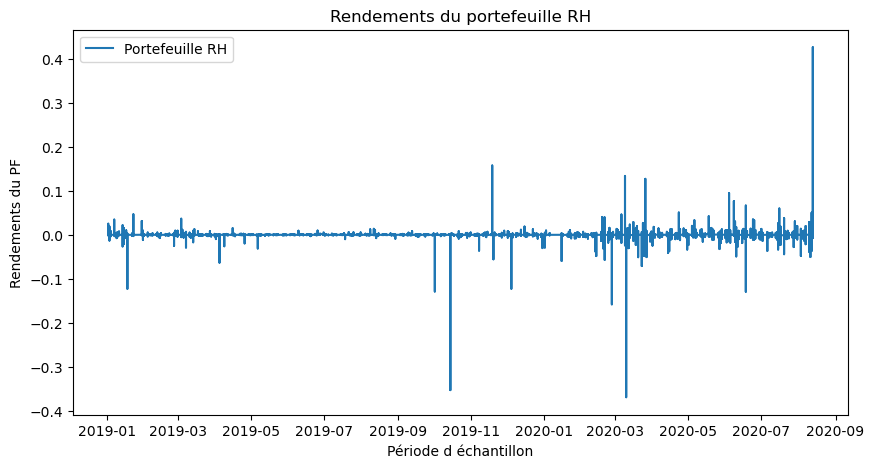

In [486]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(merged_df['date'], merged_df['portfolio_return'], label='Portefeuille RH')
ax.set_xlabel('Période d échantillon')
ax.set_ylabel('Rendements du PF')
ax.set_title('Rendements du portefeuille RH')
ax.legend()
plt.show()

Quelques statistiques de base pour le protefeuille RH et rendements du SP500 :

In [487]:
portfolio_mean = df_portfolio_returns['portfolio_return'].mean()
portfolio_std = df_portfolio_returns['portfolio_return'].std()
portfolio_min = df_portfolio_returns['portfolio_return'].min()
portfolio_max = df_portfolio_returns['portfolio_return'].max()

sp500_mean = df_SP500_selected['Change %'].mean()
sp500_std = df_SP500_selected['Change %'].std()
sp500_min = df_SP500_selected['Change %'].min()
sp500_max = df_SP500_selected['Change %'].max()

data = {
    'Portfolio RH': [portfolio_mean, portfolio_std, portfolio_min, portfolio_max],
    'S&P 500': [sp500_mean, sp500_std, sp500_min, sp500_max]
}

df_summary = pd.DataFrame(data=data, index=['Moyenne', 'Ecart-type', 'Minimum', 'Maximum'])
df_summary

,Portfolio RH,S&P 500
Moyenne,0.000433,0.087892
Ecart-type,0.167657,1.731939
Minimum,-36.950904,-11.980000
Maximum,42.694064,9.380000


Les données sont en pourcentages pour les rendements

Text(0, 0.5, 'Rendement')

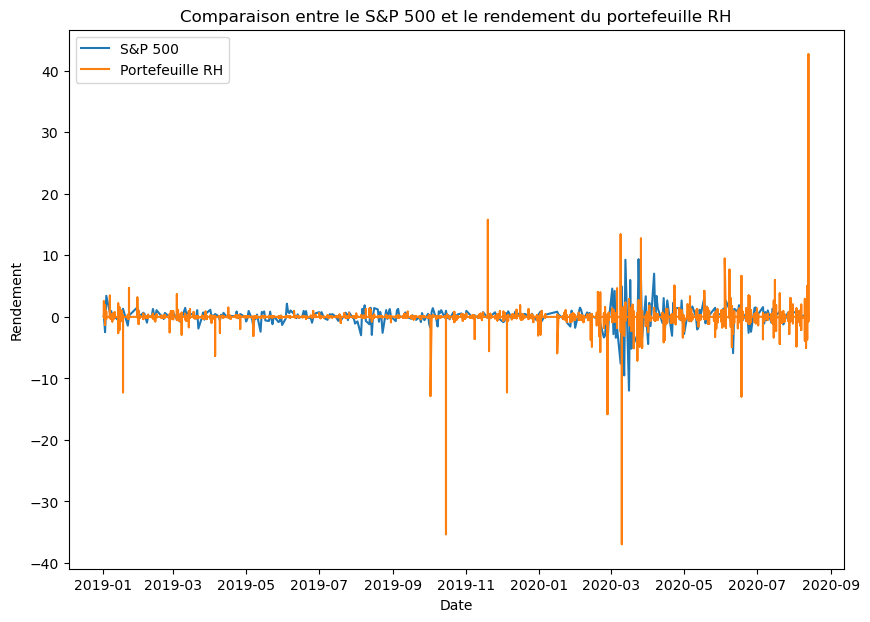

In [488]:
merged_df = pd.merge(df_SP500, df_portfolio_returns, left_on='Date', right_on='date')

# Créer un graphique avec deux lignes
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(merged_df['Date'], merged_df['Change %'], label='S&P 500')
ax.plot(merged_df['date'], merged_df['portfolio_return'], label='Portefeuille RH')

# Ajouter des légendes pour chaque ligne du graph
ax.legend()

# Nommer les axes
ax.set_title('Comparaison entre le S&P 500 et le rendement du portefeuille RH')
ax.set_xlabel('Date')
ax.set_ylabel('Rendement')

# Source: https://chat.openai.com/chat/

In [489]:
# Calcul du ratio de Sharpe (avec le nombre de jours par ans où la boruse est ouverte 252 jours) :
RH_sharpe = df_portfolio_returns['portfolio_return'].mean() / df_portfolio_returns['portfolio_return'].std() * np.sqrt(252)
SP_sharpe = df_SP500_selected['Change %'].mean() / df_SP500_selected['Change %'].std() * np.sqrt(252)

# Comparaison du ratio de Sharpe pour RH et S&P 500:
sharpe_comparaison = pd.DataFrame({'Ratio de Sharpe': [RH_sharpe, SP_sharpe]}, index=['RH Portfolio', 'S&P 500'])
sharpe_comparaison
# Source: https://chat.openai.com/chat/

,Ratio de Sharpe
RH Portfolio,0.041030
S&P 500,0.805597


Ici, c'est une deuxieme méthode de calcul qui est prise en compte, le calcul du ratio de sharpe selon la méthode "classique" en finance, avec un taux Rf sans risque des bons du trésor gouvernemental. Le but est de déterminer quelle approche donne le résultat le plus significatif, aux vues des autres statistiques obtenues jusqu'à présent.

In [490]:
# Définir un taux d'intérêt sans risque : RF (par exemple, un taux d'obligation d'État à 10 ou 15 ans) :
risk_free_rate = 0.025

# Calculer le ratio de Sharpe pour le portefeuille: 
sharpe_portfolio = (df_portfolio_returns['portfolio_return'].mean() - risk_free_rate) / df_portfolio_returns['portfolio_return'].std()
sharpe_sp500 = (df_SP500_selected['Change %'].mean()- risk_free_rate) / df_SP500_selected['Change %'].std()

sharpe_comparaison_2 = pd.DataFrame({'Ratio de Sharpe': [sharpe_portfolio, sharpe_sp500]}, index=['RH Portfolio', 'S&P 500'])
sharpe_comparaison_2

,Ratio de Sharpe
RH Portfolio,-0.146530
S&P 500,0.036313


Le ratio de Sharpe permet de mesurer la performance d'un investissement ajustée à son risque encouru, il calcule le rendement excédentaire d'un investissement en fonction de son risque intrinqèque. Il se mesure à l'aide de l'écart-type des rendements qu'on cherche à comparer, dans notre cas les rendements du portefeuille RH et les rendements du SP500.

Nous aurons besoin pour calculer le ratio de Sharpe, des rendements moyens du portefeuille RH et du S&P 500, ainsi que de l'écart type des rendements du portefeuille et du SP500 également.

Sharpe Ratio = (Rp - Rf) / σp

Où :
Rp est le rendement moyen du portefeuille,
Rf est le taux sans risque (par exemple, le taux d'intérêt sur les bons du Trésor à court terme)
σp est l'écart-type des rendements du portefeuille.

##### Cependant, il est important de noter que le calcul du ratio de Sharpe peut être affecté par des valeurs aberrantes ou des périodes de volatilité extrême, donc il est important de prendre en compte d'autres mesures de risque lors de l'évaluation des performances des investissements. C'est ce que nous allons faire dans la partie 2 de notre évaluation...

In [491]:
sp500_stats = np.percentile(df_SP500_selected['Change %'], [25, 50, 75]), np.median(df_SP500_selected['Change %']), np.std(df_SP500_selected['Change %'])

portfolio_stats = np.percentile(df_portfolio_returns['portfolio_return'], [25, 50, 75]), np.median(df_portfolio_returns['portfolio_return']), np.std(df_portfolio_returns['portfolio_return'])

# je crée un dataframe pour contenir toute l'information calculée à partir des données des portefeuilles
df_stats = pd.DataFrame({
    'Statistiques': ['25th percentile', '50th percentile', '75th percentile', 'Median', 'Standard deviation'],
    'SP500': [sp500_stats[0][0]*100, sp500_stats[0][1]*100, sp500_stats[0][2]*100, sp500_stats[1]*100, sp500_stats[2]],
    'Portfolio RH': [portfolio_stats[0][0]*100, portfolio_stats[0][1]*100, portfolio_stats[0][2]*100, portfolio_stats[1]*100, portfolio_stats[2]]
})
print(df_stats)

         Statistiques      SP500  Portfolio RH
0     25th percentile -36.000000     -0.285522
1     50th percentile  14.500000      0.003088
2     75th percentile  72.000000      0.282546
3              Median  14.500000      0.003088
4  Standard deviation   1.729815      0.167656


Ces données sont afichées en pourcentages (%)

### QUESTION 2 :
En utilisant le portefeuille que vous avez construit dans la question précédente, calculez les
mesures de risque suivantes :

In [492]:
def var_es(data, alpha):
    # Sort the data in ascending order
    sorted_data = np.sort(data)
    
    # Calculate the VaR and ES using the historical simulation method
    var = np.quantile(sorted_data, alpha)
    es = np.mean(sorted_data[sorted_data <= var])
    
    return var, es

#source : https://chat.openai.com/chat

In [493]:
# VaR et ES pour le portfolio complet à 5%
var_es_pf_RH = var_es(df_portfolio_returns["portfolio_return"], alpha=0.05)
# VaR et ES pour le portfolio complet à 1%
var_es_pf_RH1 = var_es(df_portfolio_returns["portfolio_return"], alpha=0.01)
print("Value at Risk PF RH (5% de confidence level):", var_es_pf_RH[0])
print("Expected Shortfall PF RH (5% de confidence level):", var_es_pf_RH[1])
print("Value at Risk PF RH (5% de confidence level):", var_es_pf_RH1[0])
print("Expected Shortfall PF RH (5% de confidence level):", var_es_pf_RH1[1])

Value at Risk PF RH (5% de confidence level): -0.021188693429284856
Expected Shortfall PF RH (5% de confidence level): -0.09746306683854661
Value at Risk PF RH (5% de confidence level): -0.08116324262010509
Expected Shortfall PF RH (5% de confidence level): -0.3352410367143077


In [494]:
# VaR et ES pour le portfolio complet à 5%
var_es_SP500 = var_es(df_SP500_selected["Change %"], alpha=0.05)
# VaR et ES pour le portfolio complet à 1%
var_es_SP500_1 = var_es(df_SP500_selected["Change %"], alpha=0.01)
print("Value at Risk (5% de confidence level):", var_es_SP500[0])
print("Expected Shortfall (5% de confidence level):", var_es_SP500[1])
print("Value at Risk (5% de confidence level):", var_es_SP500_1[0])
print("Expected Shortfall (5% de confidence level):", var_es_SP500_1[1])

Value at Risk (5% de confidence level): -2.5515
Expected Shortfall (5% de confidence level): -4.47952380952381
Value at Risk (5% de confidence level): -5.1597
Expected Shortfall (5% de confidence level): -8.032


### QUESTION 3

In [495]:
print(df_stock_data['DlyRet'].isnull().sum())

251


In [496]:
gme_data = df_stock_data.loc[df_stock_data["Ticker"] == "GME", "DlyRet"]

c:\Users\Thomas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 DlyRet   No. Observations:                  408
Model:                     AutoReg(1)   Log Likelihood                 611.175
Method:               Conditional MLE   S.D. of innovations              0.054
Date:                Sun, 26 Mar 2023   AIC                          -1216.349
Time:                        21:45:33   BIC                          -1204.323
Sample:                             1   HQIC                         -1211.590
                                  408                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.003     -0.365      0.715      -0.006       0.004
DlyRet.L1     -0.0100      0.050     -0.201      0.841      -0.107       0.087
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1         -100.3947           +0.0000j          100.3947            0.5000
-----------------------------------------------------------------------------
"""

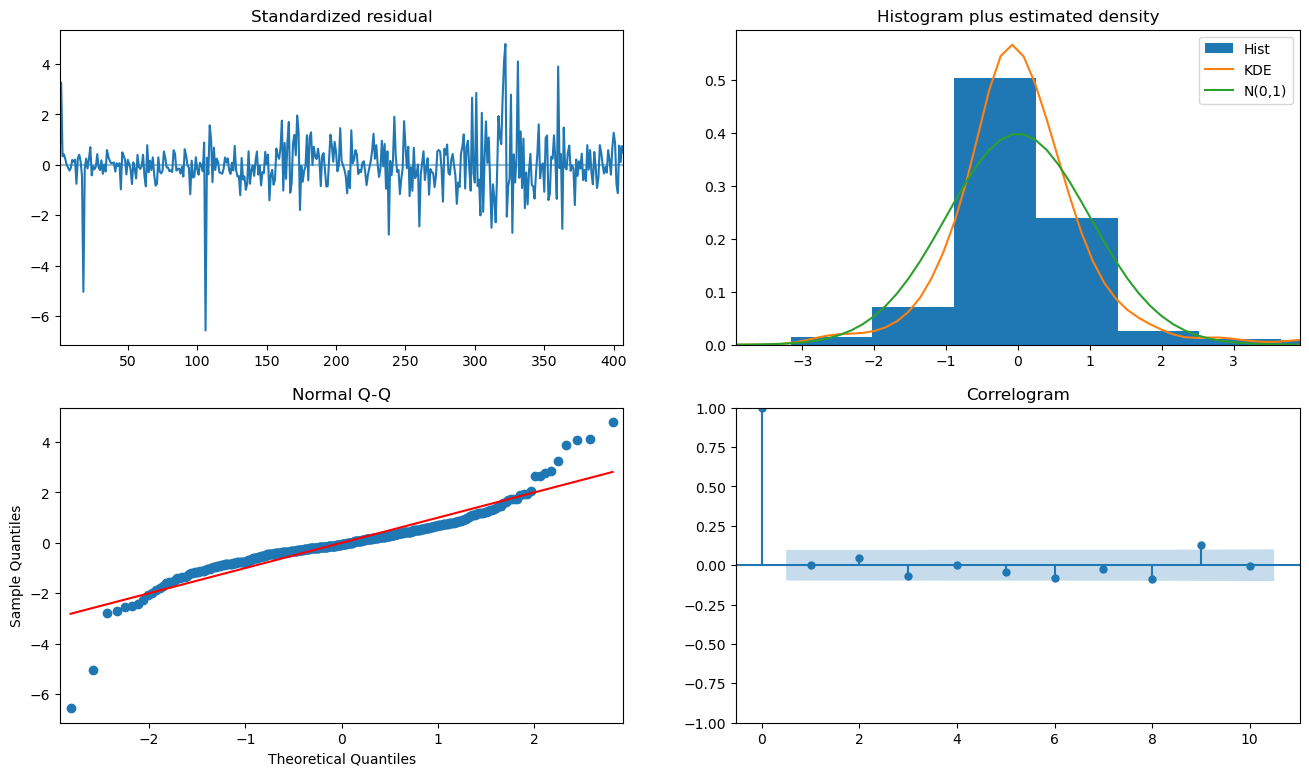

In [497]:
from statsmodels.tsa.ar_model import AutoReg

# Now let's estimate a AR model based on Gamestop returns in stock_data.csv
ARresults = AutoReg(gme_data, lags=1).fit() 
# get some diagnostics
ARresults.plot_diagnostics(figsize=[16,9])
# see the model estimates
ARresults.summary()

In [498]:
def prevision_he(res, hmax):
    #res = ARresults
    
    y_len = res.nobs + len(res.ar_lags)
    
    forecast =  ARresults.predict(start= y_len, end= (y_len + hmax -1))
    
    return forecast

In [499]:
def rollAR(s, T0, p, h):
    """
    Computes AR(p) forecasts using a rolling estimation window of size T0
    """
    df = pd.DataFrame(index=range(len(s) - T0), columns=range(1, h+1))
    for i in range(len(s) - T0):
        df.iloc[i] = prevision_he(AutoReg(s[max(0, i - p):(T0 + i)], p).fit(), h)
    df = df.to_numpy(dtype='float')
    return df

In [500]:
print(rollAR(gme_data, T0= 1000, p=3, h = 2))

[]


In [501]:
#AR(3)
from statsmodels.tsa.ar_model import AutoReg
series = gme_data
estimation_window = 10
length = 3

df_3lags = pd.DataFrame(index= range(len(gme_data) - estimation_window), columns=range(1,length+1))

for i in range(len(series) - estimation_window):
    model = AutoReg(series[i:(estimation_window + i)], lags=3).fit()
    df_3lags.iloc[i] = model.predict(start= estimation_window, end=(estimation_window+length-1))

c:\Users\Thomas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Thomas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Thomas\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
c:\Users\Thomas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, 

In [502]:
df_3lags

,1,2,3
0,-0.012103,-0.012248,-0.012606
1,-0.00097,-0.001831,-0.002794
2,-0.002265,-0.005503,-0.003554
3,-0.001452,-0.000649,-0.005816
4,0.044,-0.106752,0.216757
...,...,...,...
393,-0.028282,0.057127,0.066178
394,0.030168,0.095728,0.036741
395,0.136122,0.062002,-0.11174
396,-0.029076,0.003132,0.031042


ValueError: could not broadcast input array from shape (6,) into shape (11,)

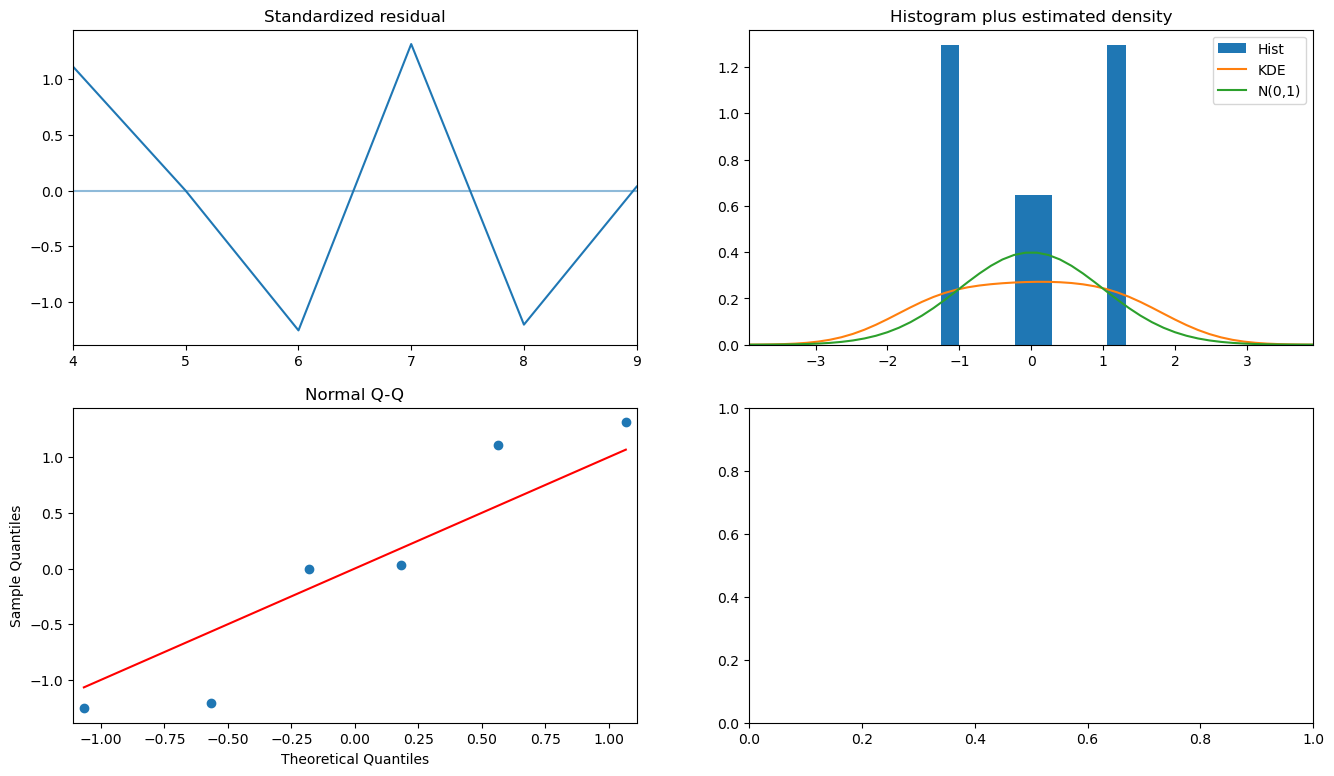

In [504]:
model.plot_diagnostics(figsize=[16,9], lags=10)

Pour construire un test d'hypothèse pour déterminer si la prévision est statistiquement différente du rendement réalisé lors de l'incident Gamestop, voici les étapes à suivre :

Formulez l'hypothèse nulle (H0) et l'hypothèse alternative (H1). Dans ce cas, H0 est que la prévision n'est pas statistiquement différente du rendement réalisé lors de l'incident Gamestop, tandis que H1 est que la prévision est statistiquement différente du rendement réalisé lors de l'incident Gamestop.

Déterminez le niveau de signification (alpha) pour le test. Par exemple, si vous utilisez un niveau de signification de 0,05, cela signifie que vous accepterez un risque de 5% de rejeter H0 même si elle est vraie.

Collectez les données nécessaires pour le test. Vous aurez besoin de la prévision initiale pour l'incident Gamestop ainsi que du rendement réalisé lors de cet incident.

Calculez la différence entre la prévision et le rendement réalisé lors de l'incident Gamestop.

Calculez la moyenne et l'écart type de la différence calculée à l'étape 4.

Calculez la statistique de test t en utilisant la formule suivante :
t = (différence de prévision et rendement réalisé - 0) / (écart type de la différence / racine carrée du nombre d'observations)

Comparez la statistique de test t calculée à la table des valeurs critiques de t pour votre niveau de signification et le nombre de degrés de liberté correspondant. Si la statistique de test t est supérieure à la valeur critique de t, cela signifie que vous pouvez rejeter H0 et accepter H1.

Interprétez les résultats du test. Si vous rejetez H0, cela signifie que la prévision est statistiquement différente du rendement réalisé lors de l'incident Gamestop. Si vous n'arrivez pas à rejeter H0, cela signifie que la prévision n'est pas statistiquement différente du rendement réalisé lors de l'incident Gamestop.

In [ ]:
# Sélectionner uniquement les lignes pour le ticker "GME"
df_gme = df_stock_data[df_stock_data["Ticker"] == "GME"]

# Sélectionner uniquement la ligne pour la date du 8 juin 2020
row_8juin = df_gme.loc[df_gme["DlyCalDt"] == "2020-06-08"]

# Extraire le rendement de la colonne "DlyRet"
prevision_GME = row_8juin["DlyRet"].values[0]

# Afficher le rendement
print("Rendement GME le 8 juin 2020:", prevision_GME)



Rendement GME le 8 juin 2020: 0.2101449275362319


In [ ]:
from scipy.stats import f

def test_statistique(prevision_GME, df_3lags):
    # Calculer la différence entre la prévision et le rendement réalisé
    diff = df_3lags - prevision_GME

    # Calculer la variance de la différence
    var_diff = np.var(diff, ddof=1)

    # Calculer la taille de l'échantillon
    n = len(diff)

    # Calculer la variance de la prévision et du rendement réalisé
    var_prevision = np.var(prevision_GME, ddof=1)
    var_rendement_realise = np.var(df_3lags, ddof=1)

    # Calculer la statistique F
    numerator = ((n-2) * var_diff)
    denominator = (var_prevision + var_rendement_realise) / 2
    f_stat = numerator / denominator

    # Calculer la valeur p associée
    p_val = 1 - f.cdf(f_stat, n-2, n-2)

    return f_stat, p_val


In [ ]:

t_stat, p_val = test_statistique(prevision_GME, df_3lags)

print("Prévision:", prevision_GME)
print("Rendement prévisionel:", df_3lags)
print("Statistique t:", t_stat)
print("Valeur p associée:", p_val)


Prévision: 0.2101449275362319
Rendement prévisionel:             1         2         3
0   -0.012103 -0.012248 -0.012606
1    -0.00097 -0.001831 -0.002794
2   -0.002265 -0.005503 -0.003554
3   -0.001452 -0.000649 -0.005816
4       0.044 -0.106752  0.216757
..        ...       ...       ...
393 -0.028282  0.057127  0.066178
394  0.030168  0.095728  0.036741
395  0.136122  0.062002  -0.11174
396 -0.029076  0.003132  0.031042
397 -0.000212  0.001068  0.001574

[398 rows x 3 columns]
Statistique t: 1   NaN
2   NaN
3   NaN
dtype: float64
Valeur p associée: [nan nan nan]


c:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3721: RuntimeWarning: Degrees of freedom <= 0 for slice
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
c:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
